# Inverse Problems & Regularization Techniques

## Introduction

In this project, we explore the use of several regularization techniques in solving inverse problems, as well as parameter estimation for these methods. 

In a usual mathematical problem, we have some formula or process, the _forward system_, that we give input to and receive output from. An _inverse problem_ is one in which we still understand the forward system, but instead of knowing the input we have observed an output and must determine what input it corresponds to. Polynomials are a simple example. Consider the polynomial $y = a_2 x^2 + a_1 x + a_0$ evaluated at $x_1 = -1$, $x_2 = 2$ (the equation and points are the forward system). A forward problem would be receiving the coefficients as input, for example $a_2 = a_1 = a_0 = 1$, and returning the pairs $(x_1, y_1) = (-1, 1)$, $(x_2, y_2) = (2, 7)$. The inverse problem here is polynomial interpolation: we are given the pairs $(x_1, y_1)$, $(x_2, y_2)$ and must determine the coefficients $a_0, a_1, a_2$. Practical examples include reconstructing data from remote sensing, fitting parameters for large systems of differential equations based on observed data, and image enhancement.

In the given example and in general, inverse problems tend to be more difficult than forward problems. Additionally, sometimes they are ill-posed, meaning that there might not exist unique solutions depending continuously on the given output. In this project we'll be using the example of images that have been blurred and had a small amount of noise added after blurring. The noise makes the problem ill-posed: though it does not change the blurred image perceptably, if we try to directly invert the blurring process the noise is massively amplified. The purpose of regularization in inverse problems is to deal with this sort of issue. We'll first look at the example of an image of a penny that has undergone a blurring/noising process, and check that we in fact cannot directly invert the process.

In [3]:
import csv
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import matrix_rank, svd
from scipy.optimize import minimize

%matplotlib inline

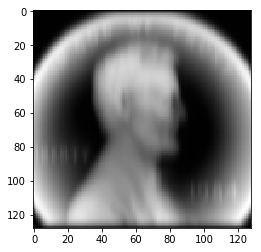

In [5]:
#import the blurred image
with open('data/penny_blur.csv', mode='r') as file:
    penny_dat = list(csv.reader(file))
    penny_dat = np.array(penny_dat, dtype=np.float)

plt.imshow(penny_dat, cmap=plt.cm.gray);

The blurring process in our case is a linear operator that models a diffusion process.

In [6]:
#blurring toeplitz matrix creator function
def blur_mat(const, n, deg):
    diag = np.diag(np.full(n, 1 - 2*const))
    sup_diag = np.diag(np.full(n-1, const), k=1)
    sub_diag = np.diag(np.full(n-1, const), k=-1)
    
    mat = diag + sup_diag + sub_diag
    mat = np.linalg.matrix_power(mat, deg)
    return np.array(mat)

blur = blur_mat(0.45, 128, 10)

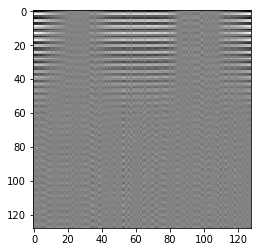

In [7]:
#invert the blurring matrix and try to recover the image
direct_deblur = np.empty_like(penny_dat)
for i in range(128):
    direct_deblur[:,i] = np.linalg.inv(blur).dot(penny_dat[:,i])

plt.imshow(direct_deblur, cmap=plt.cm.gray);

As feared, nothing is recoverable without using a more sophisticated approach.

## Truncated Singular Value Decomposition

### Mathematical Background

We view the inverse problem we wish to solve as a system of linear equations, which we write in matrix/vector form as
$$Ax = d,$$
where $d \in \mathbb{R}^n$ is a known vector representing the observed data (in this case a column of pixel values for the blurred image), $x \in \mathbb{R}^n$ is an unknown vector representing the original data (a column of pixel values for the original image), and $A \in \mathbb{R}^{n \times n}$ is a known invertible matrix representing the process to be reversed (a blurring operator). The complication is that we actually have
$$
A\hat{x} = \hat{d},
\\
\hat{d} := d + \xi
$$
where $\xi \in \mathbb{R}^n$ is an unknown vector of noise. We wish to find some approximation $\hat{x}$ of the true data $x$, but as we saw, the noisy part of $\hat{d}$ gets amplified if we try to directly invert it, drowning out the signal we want to recover.

One solution is to use the _truncated singular value decomposition_ (TSVD). [Recall](https://en.wikipedia.org/wiki/Singular-value_decomposition) that our real $n \times n$ matrix $A$ has the singular value decomposition
$$A = U\Sigma V^\mathsf{T}$$
where $U$ and $V$ are orthogonal matrices with columns $u_1, \ldots, u_n \in \mathbb{R}^n$ and $v_1, \ldots, v_n \in \mathbb{R}^n$ respectively, and $\Sigma = \mathrm{diag}(\sigma_1, \ldots, \sigma_n)$. This decomposition is unique up to the ordering of the columns and $\sigma_i$. We call the positive real values $\sigma_i$ the _singular values_ of $A$; we assume they are ordered as $\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_n > 0$. Note that if we use this form to find the inverse of $\hat{d}$ under $A$ we get
$$A^{-1}\hat{d} = (U \Sigma V^\mathsf{T})^{-1}\hat{d} = \sum_{i=1}^n \frac{u_i^\mathsf{T} \hat{d}}{\sigma_i}v_i$$
since the orthogonal matrices satisfy $U^{-1} = U^\mathsf{T}$, $V^{-1} = V^\mathsf{T}$ and the diagonal matrix satisfies $\Sigma^{-1} = \mathrm{diag}\left(\frac{1}{\sigma_1}, \ldots, \frac{1}{\sigma_n} \right)$.

From the above formula, we can see that small singular values will contribute large amounts to the inverse $A^{-1}\hat{d}$. As it turns out, such values represent what can be considered "high frequency components" of the blurring process, and in most applications such information is in fact not useful. Thus, one way to estimate the original value $x$ is to ignore some of the smaller singular values, truncating the above sum as
$$\hat{x} := \sum_{i=1}^k \frac{u_i^\mathsf{T} \hat{d}}{\sigma_i}v_i$$
for some chosen integer $1 \leq k < n$. This is exactly the TSVD method. Our main challenge in implementing it will be to choose an appropriate $k$, such that we minimize the noise without losing the signal.

Implementing TSVD is simple using numpy's `np.linalg.svd` function. We define a function `tsvd_reg` that applies to the whole image, first performing the SVD of $A$ and then applying the TSVD process column-by-column to reconstruct the original image.

In [8]:
def tsvd_reg(proc, dat, k):
    """Performs truncated singular value decomposition.
    
    Approximates the inverse of the vector dat under under the matrix process proc using the
    TSVD method with a parameter of k singular values.
    
    Args:
        proc: 2-d array-like representing the matrix describing the distortion process.
        dat: 2-d array-like representing the matrix of pixel values of the distorted image.
        k: Integer giving the number of singular values to use.
    
    Returns:
        A 2-d ndarray representing the approximate reconstruction of the original image.
    """
    proc = np.array(proc)
    dat = np.array(dat)
    m, n = dat.shape
    
    u, sv_lst, v = svd(proc) #perform singular value decomposition
    v = v.T #svd returns V^T, so transpose to recover V
    
    ### iterate over each column using the TSVD formula
    x = np.empty((m, n))
    for i in range(n):
        col = dat[:,i]
        x[:,i] = sum((np.dot(u[:,i], col) / sv_lst[i]) * v[:,i] for i in range(k))

    return x

### TSVD Test

Now, let's try this method for some different values of $k$ to see what gets the best results.

In [9]:
tsvd_params = (10, 50, 90, 100, 110, 120)
reg_tst_tsvd = []
for k in tsvd_params:
    reg_tst_tsvd.append(tsvd_reg(blur, penny_dat, k))

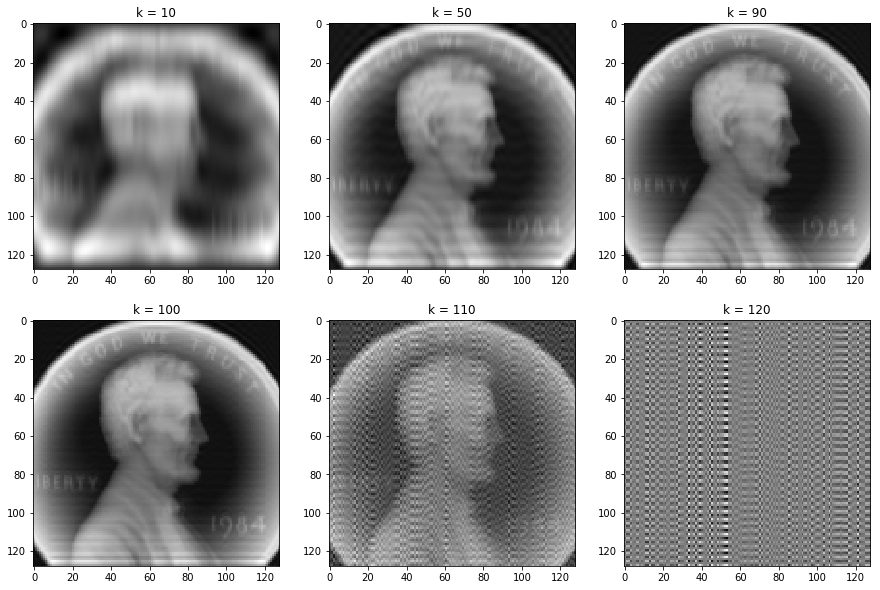

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10));
for (i,j) in it.product(range(2), range(3)):
    axes[i][j].imshow(reg_tst_tsvd[3*i + j], cmap=plt.cm.gray);
    axes[i][j].set_title('k = ' + str(tsvd_params[3*i + j]));

## Tikhonov Regularization

Another approach, and one more commonly encountered in practice, is Tikhonov regularization. We've talked about the noise in the observed data $\hat{d}$ being 'blown up' by the inversion process, and there is a literal interpretation of this: the vector $A^{-1}\hat{d}$ can be quite large. Also remember that we have two priorities: we use regularization to smooth out the noise so it doesn't dominate our result, but over-smoothing can mean we get a result that is far from the signal of the original data. Tikhonov regularization is a way to directly balance these competing concerns.

### Mathematical Background

Our first concern—noise being amplified—can be expressed as the problem of keeping $\|\hat{x}\|$, the size (Euclidean 2-norm) of our approximation, small. Fidelity to the original signal, on the other hand, is the problem of minimizing $\|A\hat{x} - \hat{d}\|$, the norm of the _residual_ of $A$ and $\hat{d}$. Note that the residual norm is zero if and only if $A\hat{x} = \hat{d}$. Tikhonov regularization is the minimization of a weighted combination of these objective functions:
$$\min_{\hat{x} \in \mathbb{R}^n} \left( \| A\hat{x} - \hat{d}\|^2  + \lambda^2 \|\hat{x}\|^2 \right), $$
where $\lambda > 0$ is the _regularization parameter_, analogous to $k$ in the TSVD approach. Larger values of $\lambda$ prioritize keeping $\hat{x}$ small, resulting in more smoothing.

For a fixed value of $\lambda$, this minimization problem's solution $\hat{x}$ is exactly the solution of the linear system
$$\left(A^\mathsf{T} A + \lambda^2 I \right)\hat{x} = A^\mathsf{T} \hat{d}.$$
Computing this in terms of the singular value decomposition of $A$, we get 
$$\hat{x} = \sum_{i=1}^n c_i \frac{u_i^\mathsf{T} \hat{d}}{\sigma_i}v_i,$$
where
$$c_i := \frac{\sigma_i^2}{\sigma_i^2 + \lambda^2}.$$
We can see that as $\lambda \rightarrow 0$ we have $\hat{x} \rightarrow A^{-1}\hat{d}$, whereas when $\lambda \rightarrow \infty$ we have $\hat{x} \rightarrow 0 \in \mathbb{R}^n$. The former extreme case is direct inversion in which noise gets amplified, and the latter is total over-smoothing in which we lose all of the signal.

In [11]:
def tikh_reg(proc, dat, l):
    """Performs Tikhonov regularization.
    
    Approximates the inverse of the vector dat under under the matrix process proc using the
    Tikhonov method with a regularization parameter of l.
    
    Args:
        proc: 2-d array-like representing the matrix describing the distortion process.
        dat: 2-d array-like representing the matrix of pixel values of the distorted image.
        l: Float determining amount of smoothing.
    
    Returns:
        A 2-d ndarray representing the approximate reconstruction of the original image.
    """
    proc = np.array(proc)
    dat = np.array(dat)
    m, n = dat.shape
    
    u, sv_lst, v = svd(proc) #perform singular value decomposition
    v = v.T #svd returns V^T, so transpose to recover V
    
    ### find vector of coefficients c_i for the Tikhonov formula
    c = sv_lst**2 / (sv_lst**2 + l**2)
    
    ### iterate over each column using the TSVD formula
    x = np.empty((m, n))
    for i in range(n):
        col = dat[:,i]
        x[:,i] = sum(c[i]*(np.dot(u[:, i], col) / sv_lst[i])*v[:, i] for i in range(n))

    return x

### Tikhonov Test

In [12]:
tikh_params = (1., 1e-4, 1e-7, 1e-8)
reg_tst_tikh = []
for l in tikh_params:
    reg_tst_tikh.append(tikh_reg(blur, penny_dat, l))

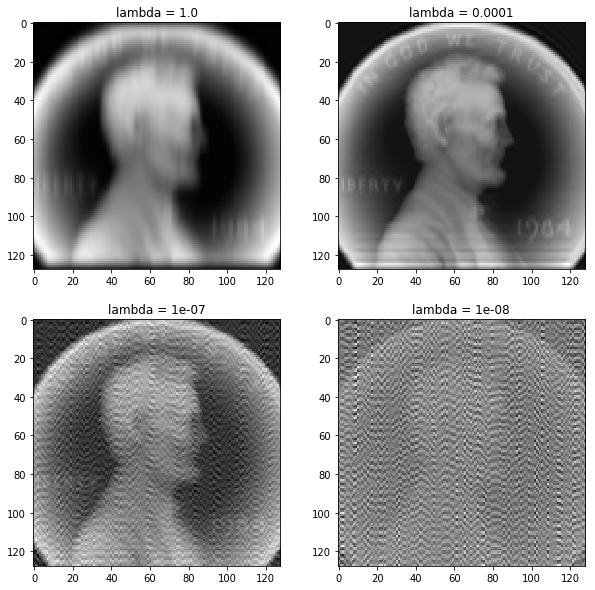

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10));
for (i,j) in it.product(range(2), range(2)):
    axes[i][j].set_title('lambda = ' + str(tikh_params[2*i + j]))
    axes[i][j].imshow(reg_tst_tikh[2*i + j], cmap=plt.cm.gray);

## Using The L-Curve for Parameter Estimation

Thus far, we have been shooting in the dark with our regularization parameter values, essentially trying arbitrary values to narrow it down. There is a more systematic way to tune our parameter though. It turns out that a characteristic of this kind of regularization is that for more aggressive regularization paramaters, for which the residual norm $\| A\hat{x} - \hat{y} \|$ is larger, the regularization term $\|\hat{x}\|$ does not vary too intensely compared to the residual norm as we change the regularization parameter. Once we pass a certain threshold by easing the regularization parameter, though, there is a dramatic increase in $\|\hat{x}\|$. Visualizing the regularization term against the residual norm in a log-log plot, this relationship looks like a capital L, and so this phenomenon is termed the L-curve. By finding the parameter just before this sudden change in behavior occurs, we can find the best balance between eliminating noise and retaining useful information. We first plot the L-curve for the TSVD.

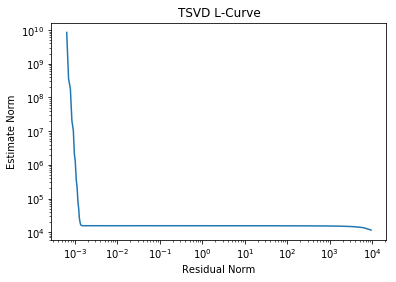

In [14]:
tsvd_lcurve = []
for k in range(1, 125):
    soln = tsvd_reg(blur, penny_dat, k)
    residual = np.linalg.norm(blur.dot(soln) - penny_dat)
    soln_norm = np.linalg.norm(soln)
    tsvd_lcurve.append([k, residual, soln_norm])
tsvd_lcurve.reverse()
tsvd_lcurve = np.array(tsvd_lcurve)

ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(tsvd_lcurve[:, 1], tsvd_lcurve[:, 2])
plt.title('TSVD L-Curve')
plt.xlabel('Residual Norm')
plt.ylabel('Estimate Norm')
plt.show()

Seeing that this occurs when the residual norm is in the interval $\left(10^{-3}, 10^{-2.5}\right)$, we can inspect the values to find a good parameter $k$ (we could do this more programmatically by finding when the difference between consecutive $k$ values first jumps, but for simplicity we manually inspect here).

In [15]:
tsvd_lcurve[(tsvd_lcurve[:,1] < 10 ** (-2.5)) & (tsvd_lcurve[:,1] > 1e-3)]

array([[1.18000000e+02, 1.02179754e-03, 1.28694952e+06],
       [1.17000000e+02, 1.07989073e-03, 3.61343769e+05],
       [1.16000000e+02, 1.12917289e-03, 2.18941262e+05],
       [1.15000000e+02, 1.18127689e-03, 8.36981327e+04],
       [1.14000000e+02, 1.23600068e-03, 4.81540673e+04],
       [1.13000000e+02, 1.27579574e-03, 2.66419168e+04],
       [1.12000000e+02, 1.31815450e-03, 2.07804738e+04],
       [1.11000000e+02, 1.36350884e-03, 1.71010869e+04],
       [1.10000000e+02, 1.40365952e-03, 1.62688182e+04],
       [1.09000000e+02, 1.44465513e-03, 1.58632527e+04],
       [1.08000000e+02, 1.48359097e-03, 1.57481065e+04],
       [1.07000000e+02, 1.53026677e-03, 1.56857487e+04],
       [1.06000000e+02, 1.57171518e-03, 1.56651595e+04],
       [1.05000000e+02, 1.61426677e-03, 1.56559430e+04],
       [1.04000000e+02, 1.65087594e-03, 1.56523619e+04],
       [1.03000000e+02, 1.72570654e-03, 1.56492555e+04],
       [1.02000000e+02, 1.77340963e-03, 1.56481748e+04],
       [1.01000000e+02, 1.88712

As we can see, the Tikhonov term begins to blow up at around $k=110$, suggesting that a little under 110, around 100 or 105, is the optimal parameter. This agrees with our above experimentation with the parameter.

Next, the Tikhonov L-curve.

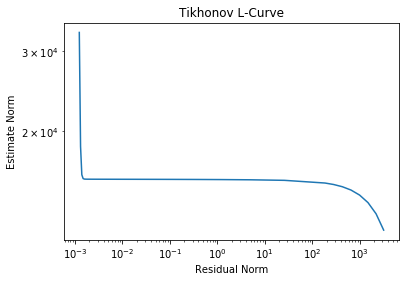

In [16]:
tikh_lcurve = []
for l in [10**(-k) for k in np.linspace(0.3, 0.9, num=7)]:
    soln = tikh_reg(blur, penny_dat, l)
    residual = np.linalg.norm(blur.dot(soln) - penny_dat)
    soln_norm = np.linalg.norm(soln)
    tikh_lcurve.append([l, residual, soln_norm])
for l in [10**(-k) for k in np.linspace(1., 8., num=15)]:
    soln = tikh_reg(blur, penny_dat, l)
    residual = np.linalg.norm(blur.dot(soln) - penny_dat)
    soln_norm = np.linalg.norm(soln)
    tikh_lcurve.append([l, residual, soln_norm])
tikh_lcurve.reverse()
tikh_lcurve = np.array(tikh_lcurve)

ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(tikh_lcurve[:, 1], tikh_lcurve[:, 2])
plt.title('Tikhonov L-Curve')
plt.xlabel('Residual Norm')
plt.ylabel('Estimate Norm')
plt.show()

In [17]:
tikh_lcurve[(tikh_lcurve[:,1] < 10 ** (-2.5)) & (tikh_lcurve[:,1] > 1e-3)]

array([[1.00000000e-08, 1.22877619e-03, 3.30465448e+04],
       [3.16227766e-08, 1.30575875e-03, 1.84878515e+04],
       [1.00000000e-07, 1.38868838e-03, 1.60046923e+04],
       [3.16227766e-07, 1.48011274e-03, 1.56925904e+04],
       [1.00000000e-06, 1.58810330e-03, 1.56531686e+04],
       [3.16227766e-06, 1.76931395e-03, 1.56468180e+04],
       [1.00000000e-05, 2.57077895e-03, 1.56439024e+04]])

For the Tikhonov method in this case, around $\lambda = 10^{-6}$ would be a good parameter.

## Generalized Tikhonov Regularization & Sobolev Norms

In our implementation of Tikhonov regularization above, we penalized approximations with large norms. But in some circumstances, such as images without sharp edges, we may be interested in preventing rapid changes or oscillation. That is to say, we might want to penalize those approximations that have large magnitude (discretized versions of) first or second derivatives.

Before investigating how to generalize the Tikhonov method to do so, we must first formalize what we mean by "discrete" derivatives of vectors. Recall that the derivative of a differentiable function $f: \mathbb{R} \rightarrow \mathbb{R}$ at a point $x$ is given by 
$$f'(x) = \lim_{\delta \rightarrow 0} \frac{f(x + \delta) - f(x)}{\delta}.$$
We can consider the pixel vector $\hat{x}$ as a function ranging over physical space, sampling the brightness of a vertical slice of the penny at regular intervals; we will treat these intervals as being length 1. In this light, $\hat{x}$ can be represented as $\hat{x}_i = f(i)$ for some $f: \{1, 2, \ldots, m\} \rightarrow \mathbb{R}$. Specifically, $f$ is the restriction of a function $F: \mathbb{R} \rightarrow \mathbb{R}$ to a set of integers. We can then define the "derivative" of $f$ at some integer (vector index) in terms of the derivative of $F$ and the limit shown above. Since we don't have access to $F$ itself, the best approximation to the above limit uses the fact that $F(i) = f(i)$ for $i = 1, 2, \ldots, m$. So we have $\delta = 1$, giving
$$f'(i) = \frac{f(i + \delta) - f(i)}{\delta} = f(i + 1) - f(i) = \hat{x}_{i+1} - \hat{x}_i$$
for $1 \leq i \leq n - 1$. Thus, this discretized derivative has the vector representation $L_1 \hat{x}$ where $L_1$ is the $(m-1)\times m$ matrix
$$
    L_1 = \left[\begin{array}{c c c c c c c}
        1 & {-1} & 0 & 0 & \cdots & & 0
        \\
        0 & 1 & {-1} & 0 & & & 
        \\
        0 & 0 & 1 & {-1} & & & \vdots
        \\
        \vdots & & & & \ddots & &
        \\
        0 & & \cdots & & & 1 & {-1}
    \end{array}\right].
$$
A similar line of reasoning, using differences of derivatives, gives us the discretization of the second derivative, $L_2 \hat{x}$, where $L_2 \in \mathbb{R}^{(m-2)\times m}$ is given by
$$
    L_2 = L_1^2 = \left[\begin{array}{c c c c c c c c c}
        1 & {-2} & 1 & 0 & 0 & & \cdots & & 0
        \\
        0 & 1 & {-2} & 1 & 0 & & & & 
        \\
        0 & 0 & 1 & {-2} & 1 & & & & \vdots
        \\
        \vdots & & & & & \ddots & & &
        \\
        0 & & \cdots & & & & 1 & {-2} & 1
    \end{array}\right].
$$
With these defined, we can now see that our penalty term for large first derivatives (rapid change) would be built from $\|L_1 \hat{x}\|$, and similarly $\|L_2 \hat{x}\|$ for the second derivative (sudden change). We could even combine these with the original by using some weighted combination $L$ of these matrices, $L := \mu_0 L_0 + \mu_1 L_1 + \mu_2 L_2$, where $L_0 := I$ is the $m\times m$ identity matrix. These are the discrete versions of _Sobolev Norms_ from functional analyis. Here, we just use $L_1$ and $L_2$ and compare to the previously used $L_0$.

In [18]:
def diff0(n):
    return np.eye(n)
    
def diff1(n):
    diag0 = np.diag(np.full(n, -1.))[:-1]
    diag1 = np.diag(np.full(n, 1.), k=1)[:-2, :-1]
    return diag0 + diag1

def diff2(n):
    diag0 = np.diag(np.full(n, 1.))[:-2]
    diag1 = np.diag(np.full(n, -2.), k=1)[:-3, :-1]
    diag2 = np.diag(np.full(n, 1.), k=2)[:-4, :-2]
    return diag0 + diag1 + diag2

We need to write a new function, because our singular value expression of Tikhonov regularization no longer works. Instead, we note that the Tikhonov solution for a given parameter $\lambda$ is the same as the solution $\hat{x}$ to
$$(A^\mathsf{T}A + \lambda^2 L^\mathsf{T}L)\hat{x} = A^\mathsf{T}\hat{d}.$$
Thus, we can invert to get
$$\hat{x} = \left(A^{-1} + \lambda^{-2}L^{-1}(L^\mathsf{T})^{-1}A^\mathsf{T}\right)\hat{d},$$
and we use this direct solution in the below function.

In [19]:
def tikh_reg_direct(proc, dat, l, diff_op=np.eye):
    proc = np.array(proc)
    dat = np.array(dat)
    m, n = dat.shape
    diff_op = np.array(diff_op(m))

    inv_mat = np.dot(proc.T, proc)
    inv_mat += l**2 * np.dot(diff_op.T, diff_op)
    inv_mat = np.linalg.inv(inv_mat)
    
    x = np.empty((m, n))
    for i in range(n):
        vec = np.dot(proc.T, dat[:,i])
        x[:,i] = np.dot(inv_mat, vec)
    
    return x

In [20]:
blur2 = blur_mat(0.45, 256, 15)

To illustrate Sobolev norms, we need an image without the stark edges found in our penny image. We will use part of a [NASA image](https://www.nasa.gov/multimedia/imagegallery/image_feature_85.html) of the surface of Mars by the Hubble space telescope (part of the development of the techniques we're using came from problems with dust blurring on early space telescopes). This has a much smoother variation of values.

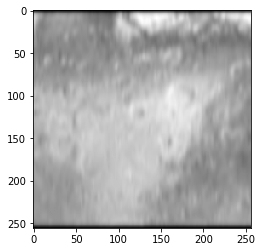

In [21]:
with open("data/mars_blur.csv", mode='r') as file:
    mars_dat = list(csv.reader(file))
    mars_dat = np.array(mars_dat, dtype=np.float)

plt.imshow(mars_dat, cmap=plt.cm.gray);

First, we use our usual Tikhonov regularization. 

In [22]:
l0tikh_params = (1., 1e-2, 1e-3, 1e-4)
reg_tst_l0tikh = []
for l in l0tikh_params:
    reg_tst_l0tikh.append(tikh_reg_direct(blur2, mars_dat, l, diff_op=diff0))

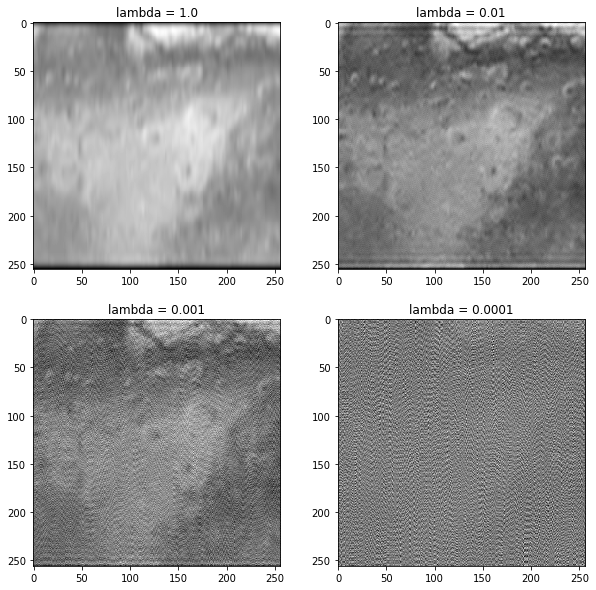

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10));
for (i,j) in it.product(range(2), range(2)):
    axes[i][j].set_title('lambda = ' + str(l0tikh_params[2*i + j]))
    axes[i][j].imshow(reg_tst_l0tikh[2*i + j], cmap=plt.cm.gray);

While it's better than the blurred image, we can do better with our Sobolev norms. First we use the discrete first derivative norm $\|L_1 \hat{x} \|$.

In [24]:
l1tikh_params = (1., 1e-1, 1e-3, 1e-4)
reg_tst_l1tikh = []
for l in l1tikh_params:
    reg_tst_l1tikh.append(tikh_reg_direct(blur2, mars_dat, l, diff_op=diff1))

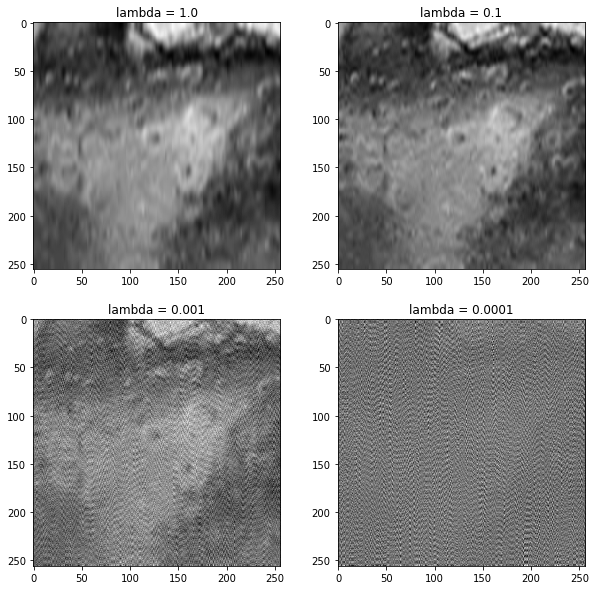

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10));
for (i,j) in it.product(range(2), range(2)):
    axes[i][j].set_title('lambda = ' + str(l1tikh_params[2*i + j]))
    axes[i][j].imshow(reg_tst_l1tikh[2*i + j], cmap=plt.cm.gray);

This is much better. Using $\|L_2 \hat{x}\|$ also provides better results.

In [26]:
l2tikh_params = (1., 1e-1, 1e-3, 1e-4)
reg_tst_l2tikh = []
for l in l2tikh_params:
    reg_tst_l2tikh.append(tikh_reg_direct(blur2, mars_dat, l, diff_op=diff2))

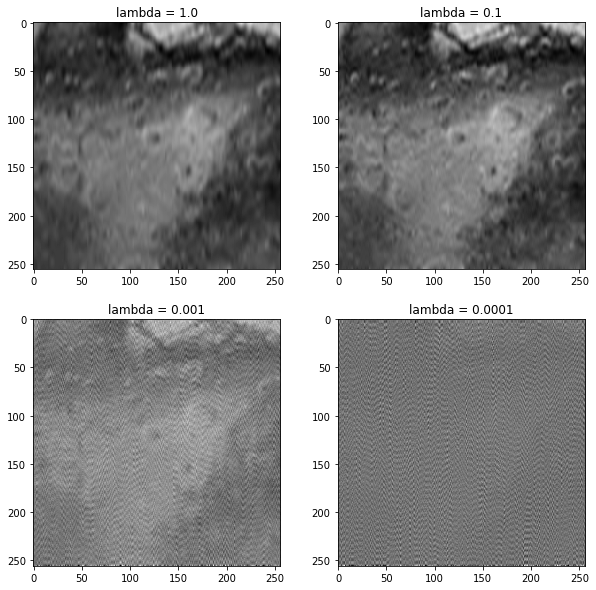

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10));
for (i,j) in it.product(range(2), range(2)):
    axes[i][j].set_title('lambda = ' + str(l2tikh_params[2*i + j]))
    axes[i][j].imshow(reg_tst_l2tikh[2*i + j], cmap=plt.cm.gray);